In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import triang
import sklearn
from pymc3.stats import hpd

In [2]:
plt.rcParams["figure.figsize"] = (16 / 3 * 2, 9 / 3 * 2)
plt.rcParams["font.size"] = 18

In [3]:
def generate_triangle_distribution_grid(theta_grid, mode):
    """
    Generate triangle distribution (grid).
    
    Parameters
    ----------
    theta_grid : list of float
        Range of theta to generate the triangle distribution.
    mode : float
        Mode of the triangle distribution.
        
    Returns
    -------
    list of float
        Normalized triangle distribution (grid)
    """
    y = [triang.pdf(x, mode) for x in theta_grid]
    y = y / np.sum(y)
    return y

In [4]:
def bernoulli_likelihood(theta, flips, heads):
    """
    Likelihood function based on Bernoulli distribution.
    
    Parameters
    ----------
    theta : float
        Probability of heads.
    flips : int
        Number of flips.
    heads : int
        Number of heads.
    
    Returns
    -------
    float
        Likelihood value.
    """
    return theta ** heads * (1 - theta) ** (flips - heads)

In [5]:
def generate_data(theta_grid, prior, data):
    """
    Generate coin flipping data.
    
    
    Parameters
    ----------
    theta_grid : list of float
        Range of probability of heads.
    prior : list of float
        Range of probability of heads.
    data : list of int
        List of observed heads vs tails.  1 is head; 0 is tail.
    
    Returns
    -------
    likelihood : list of float
        p(data|theta)
    posterior : list of float
        p(theta|data)
    """
    flips = len(data)
    heads = sum(data)

    likelihood = [
        bernoulli_likelihood(theta, flips, heads) for theta in theta_grid
    ]
    evidence = sum(likelihood * prior)
    posterior = likelihood * prior / evidence
    
    return likelihood, posterior

In [7]:
def single_plot(ax, x, y, hdi=False, random_state=None):
    """
    Bernoulli grid plot helper.
    
    Create histogram plots, mode, x-axis label = "theta", and HDI (optional).
    
    Parameters
    ----------
    ax : matplotlib.axes
        Axis to plot.
    x : list of float
        Bins of histogram.
    y : list of float.
        Histogram values.
    hdi : bool, optional (default=False)
        If True, HDI will be plotted
    random_state : int, RandomState instance or None, optional (default=None)
        If int, random_state is the seed used by the random number generator;
        If RandomState instance, random_state is the random number generator;
        If None, the random number generator is the RandomState instance used
        by `np.random`.
    """
    ax.bar(x, y, width=x[1] * 0.6, alpha=0.5)
    
    ylim = ax.get_ylim()
    ax.text(0.75, ylim[1] * 0.9, f"mode={x[np.argmax(y)]:.3f}")
    
    ax.set_xlabel("theta")
    
    if hdi:
        hdi_x, hdi_y = calc_hdi(y, x, 1_000_000, random_state)

        ax.plot(hdi_x + np.diff(x[:2]), [hdi_y]*2, 'k')
        ax.text(hdi_x[0] - 0.05, hdi_y + 0.001, f"{hdi_x[0]:.2f}")
        ax.text(hdi_x[1] - 0.05, hdi_y + 0.001, f"{hdi_x[1]:.2f}")
        ax.text(np.diff(hdi_x) / 2, hdi_y + 0.001, f"95% HDI")

In [28]:
def calc_hdi(hist, bins, size, random_state=None):
    """
    Estimate HDI from histogram of probability.
    
    Data is sampled with the given probability and
    HDI is calculated with pymc3.stats.hpd
    
    Parameters
    ----------
    hist : list of float
        Histogram of probability.
    bins : list of float
        Bins of the histogram.
    size : int
        Number of samples to generate.
    random_state : int, RandomState instance or None, optional (default=None)
        If int, random_state is the seed used by the random number generator;
        If RandomState instance, random_state is the random number generator;
        If None, the random number generator is the RandomState instance used
        by `np.random`.
        
    Returns
    -------
    hdi_x : [float, float]
        HDI range.
    hdi_y : float
        Probability value corresponding to the HDI.
    """
    rng = sklearn.utils.check_random_state(random_state)
    samples = rng.choice(bins, size=size, p=hist)
    hdi_x = [float(x + np.diff(bins[:2])) for x in hpd(samples)]
    hdi_y = np.mean([
        hist[np.argwhere(np.abs(bins - x) < 1e-6).ravel()[0]+1] for x in hdi_x
    ])
    return hdi_x, hdi_y

In [8]:
def plot_bernoulli_grid(theta_grid, prior, likelihood, posterior, rng):
    """
    Create prior, likelihood, and posterior plots for Bernoulli trials (grid).
    
    Parameters
    ----------
    theta_grid : list of float
        Grid of the probability of heads.
    prior : list of float
        Grid of prior.
    likelihood : list of float
        Grid of likelihood.
    posterior : list of float
        Grid of posterior.
    random_state : int, RandomState instance or None, optional (default=None)
        If int, random_state is the seed used by the random number generator;
        If RandomState instance, random_state is the random number generator;
        If None, the random number generator is the RandomState instance used
        by `np.random`.
    """
    plt.rcParams["font.size"] = 14

    fig = plt.figure(figsize=(16 / 5 * 2, 9 / 5 * 2 * 3))

    width = np.diff(theta_grid[:2]) * 0.6

    ax1 = fig.add_subplot(311)
    single_plot(ax1, theta_grid, prior, True, rng)
    ax1.set_ylabel("p(theta)")
    ax1.set_title("Prior")


    ax2 = fig.add_subplot(312)
    single_plot(ax2, theta_grid, likelihood)
    ax2.text(0.63, 0.082, "Data: z = 1, N = 4")
    ax2.set_ylabel("p(data|theta)")
    ax2.set_title("Likelihood")

    ax3 = fig.add_subplot(313)
    single_plot(ax3, theta_grid, posterior, True, rng)
    ax3.set_ylabel("p(theta|data)")
    ax3.set_title("Posterior")

    plt.subplots_adjust(hspace=0.5)

    plt.show()

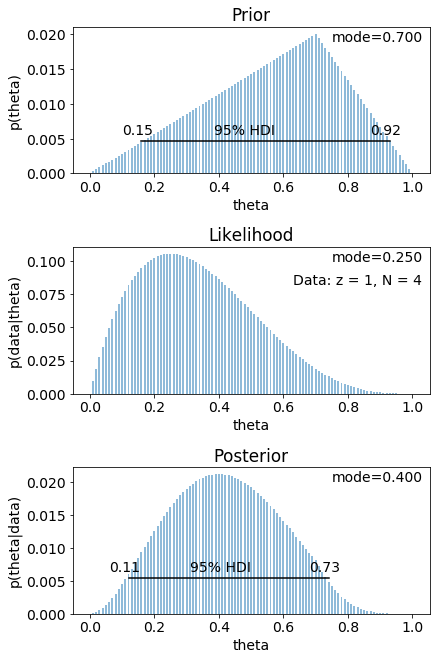

In [29]:
rng = np.random.RandomState(0)
theta_grid = np.linspace(0, 1, 101)
prior = generate_triangle_distribution_grid(theta_grid, 0.7)
likelihood, posterior = generate_data(theta_grid, prior, [0, 0, 0, 1])
plot_bernoulli_grid(theta_grid, prior, likelihood, posterior, rng)